In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

class A2C():
    def __init__(self,
                 actor_critic,
                 value_loss_coef,
                 entropy_coef,
                 lr=None,
                 eps=None,
                 alpha=None,
                 max_grad_norm=None):

        self.summary_writer = SummaryWriter()
        self.actor_critic = actor_critic
        

        self.value_loss_coef = value_loss_coef
        self.entropy_coef = entropy_coef

        self.max_grad_norm = max_grad_norm

        
        self.optimizer = optim.RMSprop(
            actor_critic.parameters(), lr, eps=eps, alpha=alpha)

    def update(self, rollouts, episode_num):
        obs_shape = rollouts.obs.size()[2:]
        action_shape = rollouts.actions.size()[-1]
        num_steps, num_processes, _ = rollouts.rewards.size()

        values, action_log_probs, dist_entropy, _ = self.actor_critic.evaluate_actions(
            rollouts.obs[:-1].view(-1, *obs_shape),
            rollouts.recurrent_hidden_states[0].view(
                -1, self.actor_critic.recurrent_hidden_state_size),
            rollouts.masks[:-1].view(-1, 1),
            rollouts.actions.view(-1, action_shape))

        values = values.view(num_steps, num_processes, 1)
        action_log_probs = action_log_probs.view(num_steps, num_processes, 1)

        advantages = rollouts.returns[:-1] - values
        value_loss = advantages.pow(2).mean()

        action_loss = -(advantages.detach() * action_log_probs).mean()

        self.optimizer.zero_grad()
        (value_loss * self.value_loss_coef + action_loss -
         dist_entropy * self.entropy_coef).backward()

        self.summary_writer.add_scalar('value_loss', value_loss.item(), episode_num)
        self.summary_writer.add_scalar('action_loss', action_loss.item(), episode_num)
        self.summary_writer.add_scalar('dist_entropy', dist_entropy.item(), episode_num)
        nn.utils.clip_grad_norm_(self.actor_critic.parameters(),
                                     self.max_grad_norm)

        self.optimizer.step()

        return value_loss.item(), action_loss.item(), dist_entropy.item()

In [9]:
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler


def _flatten_helper(T, N, _tensor):
    return _tensor.view(T * N, *_tensor.size()[2:])


class RolloutStorage(object):
    def __init__(self, num_steps, num_processes, obs_shape, action_space,
                 recurrent_hidden_state_size):
        self.obs = torch.zeros(num_steps + 1, num_processes, *obs_shape)
        self.recurrent_hidden_states = torch.zeros(
            num_steps + 1, num_processes, recurrent_hidden_state_size)
        self.rewards = torch.zeros(num_steps, num_processes, 1)
        self.value_preds = torch.zeros(num_steps + 1, num_processes, 1)
        self.returns = torch.zeros(num_steps + 1, num_processes, 1)
        self.action_log_probs = torch.zeros(num_steps, num_processes, 1)
        #if action_space.__class__.__name__ == 'Discrete':
        action_shape = 1
        #else:
        #    action_shape = action_space.shape[0]
        self.actions = torch.zeros(num_steps, num_processes, action_shape)
        if action_space.__class__.__name__ == 'Discrete':
            self.actions = self.actions.long()
        self.masks = torch.ones(num_steps + 1, num_processes, 1)

        # Masks that indicate whether it's a true terminal state
        # or time limit end state
        self.bad_masks = torch.ones(num_steps + 1, num_processes, 1)

        self.num_steps = num_steps
        self.step = 0

    def to(self, device):
        self.obs = self.obs.to(device)
        self.recurrent_hidden_states = self.recurrent_hidden_states.to(device)
        self.rewards = self.rewards.to(device)
        self.value_preds = self.value_preds.to(device)
        self.returns = self.returns.to(device)
        self.action_log_probs = self.action_log_probs.to(device)
        self.actions = self.actions.to(device)
        self.masks = self.masks.to(device)
        self.bad_masks = self.bad_masks.to(device)

    def insert(self, obs, recurrent_hidden_states, actions, action_log_probs,
               value_preds, rewards, masks, bad_masks):
        self.obs[self.step + 1].copy_(obs)
        self.recurrent_hidden_states[self.step +
                                     1].copy_(recurrent_hidden_states)
        self.actions[self.step].copy_(actions)
        self.action_log_probs[self.step].copy_(action_log_probs)
        self.value_preds[self.step].copy_(value_preds)
        self.rewards[self.step].copy_(rewards)
        self.masks[self.step + 1].copy_(masks)
        self.bad_masks[self.step + 1].copy_(bad_masks)

        self.step = (self.step + 1) % self.num_steps

    def after_update(self):
        self.obs[0].copy_(self.obs[-1])
        self.recurrent_hidden_states[0].copy_(self.recurrent_hidden_states[-1])
        self.masks[0].copy_(self.masks[-1])
        self.bad_masks[0].copy_(self.bad_masks[-1])

    def compute_returns(self,
                        next_value,
                        use_gae,
                        gamma,
                        gae_lambda,
                        use_proper_time_limits=True):
        if use_proper_time_limits:
            if use_gae:
                self.value_preds[-1] = next_value
                gae = 0
                for step in reversed(range(self.rewards.size(0))):
                    delta = self.rewards[step] + gamma * self.value_preds[
                        step + 1] * self.masks[step +
                                               1] - self.value_preds[step]
                    gae = delta + gamma * gae_lambda * self.masks[step +
                                                                  1] * gae
                    gae = gae * self.bad_masks[step + 1]
                    self.returns[step] = gae + self.value_preds[step]
            else:
                self.returns[-1] = next_value
                for step in reversed(range(self.rewards.size(0))):
                    self.returns[step] = (self.returns[step + 1] * \
                        gamma * self.masks[step + 1] + self.rewards[step]) * self.bad_masks[step + 1] \
                        + (1 - self.bad_masks[step + 1]) * self.value_preds[step]
        else:
            if use_gae:
                self.value_preds[-1] = next_value
                gae = 0
                for step in reversed(range(self.rewards.size(0))):
                    delta = self.rewards[step] + gamma * self.value_preds[
                        step + 1] * self.masks[step +
                                               1] - self.value_preds[step]
                    gae = delta + gamma * gae_lambda * self.masks[step +
                                                                  1] * gae
                    self.returns[step] = gae + self.value_preds[step]
            else:
                self.returns[-1] = next_value
                for step in reversed(range(self.rewards.size(0))):
                    self.returns[step] = self.returns[step + 1] * \
                        gamma * self.masks[step + 1] + self.rewards[step]

    

In [10]:
NUM_STEP = 850  # Cap the number of steps to run for each env
NUM_PROCESSES = 1  # Number of processes to use
ENV_DIM = 4  # Dimension of one size of the building zone in the env
NUM_ACTION = 8  # Number of actions in the action space
NUM_EPISODE = 1000
NUM_STEP_TOTAL = NUM_STEP * NUM_EPISODE 
GAMMA = 0.99  # Discount factor
VALUE_COEFF = 0.5  # Value loss coefficient
ENTROPY_COEFF = 0.01  # Entropy regularisation coefficient
LR = 0.0000625
RMS_EPSILON = 0.1
RMS_ALPHA = 0.99

RECURRENT_HIDDEN_SIZE = 256  # Size of the hidden state in the actor-critic model
USE_LR_DECAY = False

In [11]:
def init(module, weight_init, bias_init, gain=1):
    weight_init(module.weight.data, gain=gain)
    bias_init(module.bias.data)
    return module

# Categorical
class FixedCategorical(torch.distributions.Categorical):
    def sample(self):
        return super().sample().unsqueeze(-1)

    def log_probs(self, actions):
        return (
            super()
            .log_prob(actions.squeeze(-1))
            .view(actions.size(0), -1)
            .sum(-1)
            .unsqueeze(-1)
        )

    def mode(self):
        return self.probs.argmax(dim=-1, keepdim=True)

class Categorical(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Categorical, self).__init__()

        init_ = lambda m: init(
            m,
            nn.init.orthogonal_,
            lambda x: nn.init.constant_(x, 0),
            gain=0.01)

        self.linear = init_(nn.Linear(num_inputs, num_outputs))

    def forward(self, x):
        x = self.linear(x)
        return FixedCategorical(logits=x)

In [12]:
class Policy(nn.Module):
    def __init__(self, obs_shape, action_space, base, base_kwargs=None):
        super(Policy, self).__init__()
        if base_kwargs is None:
            base_kwargs = {}

        self.base = base(obs_shape[-1], **base_kwargs)
        #print("action_space", action_space.__class__.__name__)
        #if action_space.__class__.__name__ == "Discrete":
        num_outputs = NUM_ACTION
        self.dist = Categorical(self.base.output_size, num_outputs)
        #else:
           # raise NotImplementedError

    @property
    def is_recurrent(self):
        return self.base.is_recurrent

    @property
    def recurrent_hidden_state_size(self):
        """Size of rnn_hx."""
        return self.base.recurrent_hidden_state_size

    def forward(self, inputs, rnn_hxs, masks):
        raise NotImplementedError

    def act(self, inputs, rnn_hxs, masks, deterministic=False):
        value, actor_features, rnn_hxs = self.base(inputs, rnn_hxs, masks)
        dist = self.dist(actor_features)

        if deterministic:
            action = dist.mode()
        else:
            action = dist.sample()

        action_log_probs = dist.log_probs(action)
        #dist_entropy = dist.entropy().mean()

        return value, action, action_log_probs, rnn_hxs

    def get_value(self, inputs, rnn_hxs, masks):
        value, _, _ = self.base(inputs, rnn_hxs, masks)
        return value

    def evaluate_actions(self, inputs, rnn_hxs, masks, action):
        value, actor_features, rnn_hxs = self.base(inputs, rnn_hxs, masks)
        dist = self.dist(actor_features)

        action_log_probs = dist.log_probs(action)
        dist_entropy = dist.entropy().mean()

        return value, action_log_probs, dist_entropy, rnn_hxs

In [13]:
class NNBase(nn.Module):
    def __init__(self, recurrent, recurrent_input_size, hidden_size):
        super(NNBase, self).__init__()

        self._hidden_size = hidden_size
        self._recurrent = recurrent

        if recurrent:
            self.gru = nn.GRU(recurrent_input_size, hidden_size)
            for name, param in self.gru.named_parameters():
                if 'bias' in name:
                    nn.init.constant_(param, 0)
                elif 'weight' in name:
                    nn.init.orthogonal_(param)

    @property
    def is_recurrent(self):
        return self._recurrent

    @property
    def recurrent_hidden_state_size(self):
        if self._recurrent:
            return self._hidden_size
        return 1

    @property
    def output_size(self):
        return self._hidden_size

    def _forward_gru(self, x, hxs, masks):
        if x.size(0) == hxs.size(0):
            x, hxs = self.gru(x.unsqueeze(0), (hxs * masks).unsqueeze(0))
            x = x.squeeze(0)
            hxs = hxs.squeeze(0)
        else:
            # x is a (T, N, -1) tensor that has been flatten to (T * N, -1)
            N = hxs.size(0)
            T = int(x.size(0) / N)

            # unflatten
            x = x.view(T, N, x.size(1))

            # Same deal with masks
            masks = masks.view(T, N)

            # Let's figure out which steps in the sequence have a zero for any agent
            # We will always assume t=0 has a zero in it as that makes the logic cleaner
            has_zeros = ((masks[1:] == 0.0) \
                            .any(dim=-1)
                            .nonzero()
                            .squeeze()
                            .cpu())

            # +1 to correct the masks[1:]
            if has_zeros.dim() == 0:
                # Deal with scalar
                has_zeros = [has_zeros.item() + 1]
            else:
                has_zeros = (has_zeros + 1).numpy().tolist()

            # add t=0 and t=T to the list
            has_zeros = [0] + has_zeros + [T]

            hxs = hxs.unsqueeze(0)
            outputs = []
            for i in range(len(has_zeros) - 1):
                # We can now process steps that don't have any zeros in masks together!
                # This is much faster
                start_idx = has_zeros[i]
                end_idx = has_zeros[i + 1]

                rnn_scores, hxs = self.gru(
                    x[start_idx:end_idx],
                    hxs * masks[start_idx].view(1, -1, 1))

                outputs.append(rnn_scores)

            # assert len(outputs) == T
            # x is a (T, N, -1) tensor
            x = torch.cat(outputs, dim=0)
            # flatten
            x = x.view(T * N, -1)
            hxs = hxs.squeeze(0)

        return x, hxs

class CNNBase(NNBase):
    def __init__(self, num_inputs, recurrent=False, hidden_size=1024):
        super(CNNBase, self).__init__(recurrent, hidden_size, hidden_size)

        init_ = lambda m: init(m, nn.init.orthogonal_, lambda x: nn.init.
                               constant_(x, 0), nn.init.calculate_gain('relu'))

        
        self.conv1 = init_(nn.Conv3d(3, 29, 3, 1, 1))
        self.conv2 = init_(nn.Conv3d(32, 67, 3, 1, 1))
        self.fc1 = init_(nn.Linear((67 + 3) * ENV_DIM * ENV_DIM * ENV_DIM, 1024))
        
        init_ = lambda m: init(m, nn.init.orthogonal_, lambda x: nn.init.
                               constant_(x, 0))
        self.critic_linear = init_(nn.Linear(hidden_size, 1))

        self.train()

    def forward(self, inputs, rnn_hxs, masks):
        original_input = inputs
        
        x = self.conv1(original_input)
        x = torch.cat((x, original_input), dim=1)
        x = nn.ReLU()(x)
        
        x = self.conv2(x)
        x = torch.cat((x, original_input), dim=1)
        x = nn.ReLU()(x)
        #print(x.shape)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        
        
        if self.is_recurrent:
            x, rnn_hxs = self._forward_gru(x, rnn_hxs, masks)

        return self.critic_linear(x), x, rnn_hxs

c:\Users\tutha\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\tutha\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.get_obs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_obs` for environment variables or `env.get_wrapper_attr('get_obs')` that will search the reminding wrappers.
  logger.warn(
c:\Users\tutha\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Updates 0, num timesteps 850, FPS 249 
 Last 10 training episodes: mean/median reward -2.6/-1.0, min/max reward -5.0/-1.0



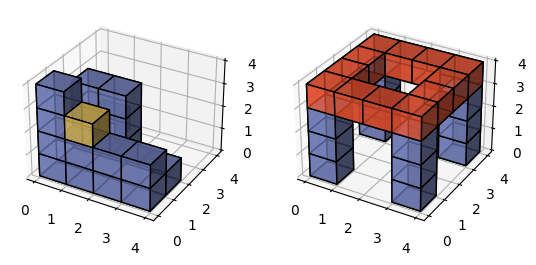

Updates 5, num timesteps 5100, FPS 261 
 Last 10 training episodes: mean/median reward -1.7/-1.0, min/max reward -5.0/-0.2



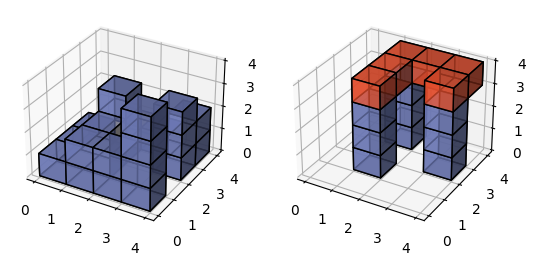

Updates 10, num timesteps 9350, FPS 256 
 Last 10 training episodes: mean/median reward -2.2/-1.0, min/max reward -5.0/-1.0



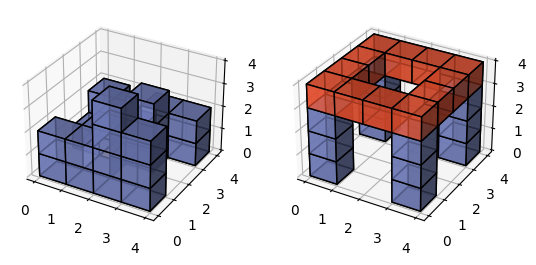

Updates 15, num timesteps 13600, FPS 251 
 Last 10 training episodes: mean/median reward -2.2/-1.0, min/max reward -5.0/-1.0



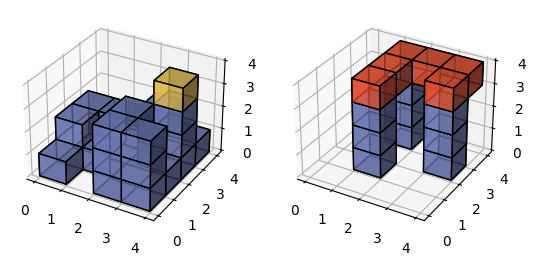

KeyboardInterrupt: 

In [14]:

import time
from collections import deque

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import GridWorld_env
def main():

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    n_actions = 8
    env = gym.make("GridWorld_env/GridWorld", dimension_size=4, path="targets")
    env.reset()


    actor_critic = Policy(
        obs_shape=(3, ENV_DIM, ENV_DIM, ENV_DIM),
        action_space=n_actions,
        base=CNNBase,
        )
    actor_critic.to(device)
    
    
    agent = A2C(
        actor_critic=actor_critic,
        value_loss_coef=VALUE_COEFF,
        entropy_coef=ENTROPY_COEFF,
        lr=LR,
        eps=RMS_EPSILON,
        alpha=RMS_ALPHA,
        max_grad_norm=5
    )
    """
    if args.gail:
        assert len(envs.observation_space.shape) == 1
        discr = gail.Discriminator(
            envs.observation_space.shape[0] + envs.action_space.shape[0], 100,
            device)
        file_name = os.path.join(
            args.gail_experts_dir, "trajs_{}.pt".format(
                args.env_name.split('-')[0].lower()))
        
        expert_dataset = gail.ExpertDataset(
            file_name, num_trajectories=4, subsample_frequency=20)
        drop_last = len(expert_dataset) > args.gail_batch_size
        gail_train_loader = torch.utils.data.DataLoader(
            dataset=expert_dataset,
            batch_size=args.gail_batch_size,
            shuffle=True,
            drop_last=drop_last)"""

    rollouts = RolloutStorage(num_steps=NUM_STEP, num_processes=NUM_PROCESSES,
                              obs_shape=(3, ENV_DIM, ENV_DIM, ENV_DIM), action_space=NUM_ACTION,
                              recurrent_hidden_state_size=RECURRENT_HIDDEN_SIZE)

    obs = env.get_obs()
    obs = torch.from_numpy(obs).float()
    rollouts.obs[0].copy_(obs)
    rollouts.to(device)

    episode_rewards = deque(maxlen=10)

    start = time.time()
    num_updates = int(
        NUM_STEP_TOTAL) // NUM_STEP // NUM_PROCESSES
    for j in range(num_updates):
        env.reset()
        """if USE_LR_DECAY:
            # decrease learning rate linearly
            utils.update_linear_schedule(
                agent.optimizer, j, num_updates,
                agent.optimizer.lr if args.algo == "acktr" else args.lr)"""

        for step in range(NUM_STEP):
            # Sample actions
            with torch.no_grad():
                value, action, action_log_prob, recurrent_hidden_states = actor_critic.act(
                    rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                    rollouts.masks[step])

            # Obser reward and next obs
            obs, reward, done, truncated, infos = env.step(action)
            obs = torch.from_numpy(obs).float()
            
            done = [done]
            episode_rewards.append(reward)

            # If done then clean the history of observations.
            masks = torch.FloatTensor(
                [[0.0] if done_ else [1.0] for done_ in done])
            """bad_masks = torch.FloatTensor(
                [[0.0] if 'bad_transition' in info.keys() else [1.0]
                 for info in infos])"""
                 
            bad_masks = torch.FloatTensor(
                [[0.0] if done_ else [1.0] for done_ in done])
            
            rollouts.insert(obs, recurrent_hidden_states, action,
                            action_log_prob, value, reward, masks, bad_masks)

        with torch.no_grad():
            next_value = actor_critic.get_value(
                rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                rollouts.masks[-1]).detach()

        """if args.gail:
            if j >= 10:
                env.venv.eval()

            gail_epoch = args.gail_epoch
            if j < 10:
                gail_epoch = 100  # Warm up
            for _ in range(gail_epoch):
                discr.update(gail_train_loader, rollouts,
                             utils.get_vec_normalize(env)._obfilt)

            for step in range(NUM_STEP):
                rollouts.rewards[step] = discr.predict_reward(
                    rollouts.obs[step], rollouts.actions[step], args.gamma,
                    rollouts.masks[step])"""

        rollouts.compute_returns(next_value, use_gae=False, gamma=GAMMA,
                                 gae_lambda=0, use_proper_time_limits=False)

        value_loss, action_loss, dist_entropy = agent.update(rollouts, j)

        rollouts.after_update()

        # save for every interval-th episode or for the last epoch
        if (j % 200 == 0
                or j == num_updates - 1):

            torch.save(#[
                actor_critic,
                #getattr(utils.get_vec_normalize(env), 'obs_rms', None)],
            "A2C_checkpoint_" + str(j) + ".pt")

        if j % 5 == 0 and len(episode_rewards) > 1:
            total_num_steps = (j + 1) * NUM_PROCESSES * NUM_STEP
            end = time.time()
            print(
                "Updates {}, num timesteps {}, FPS {} \n Last {} training episodes: mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}\n"
                .format(j, total_num_steps,
                        int(total_num_steps / (end - start)),
                        len(episode_rewards), np.mean(episode_rewards),
                        np.median(episode_rewards), np.min(episode_rewards),
                        np.max(episode_rewards), dist_entropy, value_loss,
                        action_loss))
            env.render()


if __name__ == "__main__":
    main()

In [ ]:

env.reset()
for i in count():
    
    action, _, _, _, _ = net(torch.from_numpy(env.get_obs()).unsqueeze(0).float().cuda())
    env.step(action.cpu().numpy())
    env.render()
    display.clear_output(wait=True)
    


KeyboardInterrupt: 